In [1]:
import vaex
import numpy as np
import matplotlib.pyplot as plt
np.warnings.filterwarnings('ignore')

In [2]:
import astropy
import astropy.units as u
from astropy.coordinates import SkyCoord, EarthLocation
import h5py

## Aurigaia 

List of possible files:
- `H_Au06_Ext`
- `I_Au06_Ext`
- `I_Au06_NoExt`

In [3]:
filename = './data/mocks/ICC_ext_Au06'
# filename = './data/I_Au06_Ext'
csv_filename = filename + '.csv'
hdf_filename = filename + '.hdf5'
box = vaex.open(hdf_filename)
box.info()

# Old reading from the CSV file. Do this once, and convert it to a HDF5
# df = vaex.from_csv(csv_filename, convert=hdf_filename, comment='#') # , convert=True)

In [4]:
# box['ld'] = box['l'] * 360 / (2*np.pi)
# box['bd'] = box['b'] * 360 / (2*np.pi)

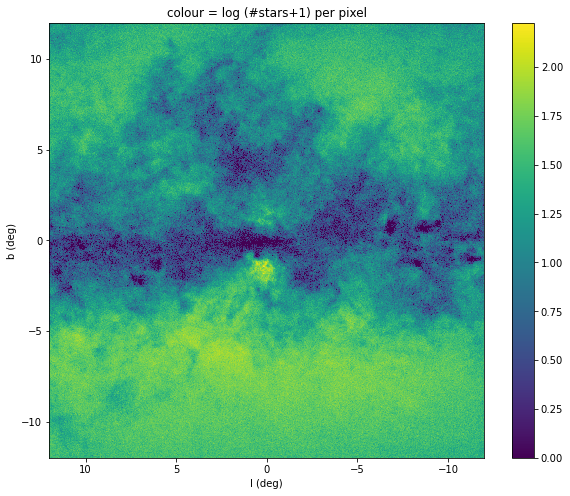

In [5]:
# Manual plot:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

limit = 12
bins = np.log10(1 + box.count(binby=['l_wrap', 'b'], limits=(-limit, limit), shape=500))
im = ax.imshow(bins.T, extent=[-limit, limit, -limit, limit], origin='lower', interpolation='None')

fig.colorbar(im, ax=ax)

ax.set_title("colour = log (#stars+1) per pixel")
ax.invert_xaxis()
ax.set_xlabel('l (deg)')
ax.set_ylabel('b (deg)')
plt.show()

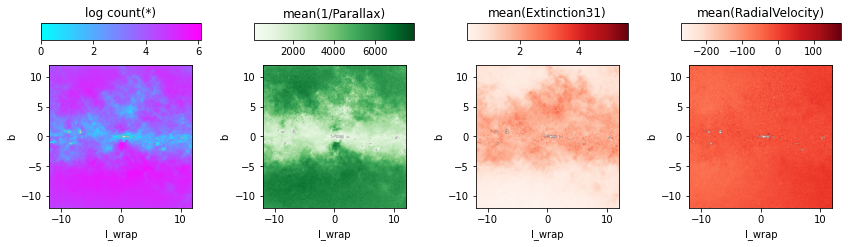

In [6]:
# A nice progress bar:
#with vaex.progress.tree('rich', title='Making heatmaps'):
# Mainly showing that we can indeed plot everything & trying out vaex
box.viz.heatmap([['l_wrap', 'b']],
                what=[
                    "count(*)", "mean(1/Parallax)",
                    "mean(Extinction31)", "mean(RadialVelocity)"
                ],
                f=['log', None, None, None],
                figsize=(12, 3.5),
                colormap=['cool', 'Greens', 'Reds', 'Reds'],
                aspect=1,
                interpolation='bilinear')

## Snapshot data

In [7]:
snap = vaex.open('./data/snapshot_halo_06_custom.hdf5')
snap.info()

In [8]:
with vaex.progress.tree('rich', title='Joining datasets'):
    master = box.join(snap, left_on='ParticleID', right_on='ParticleIDs', rprefix='SNAP_')

Output()

In [9]:
master.info()

## Abundances

### Compare to sun
$$\log \varepsilon_X = \log(N_X / N_H) + 12$$
$$\log \varepsilon_{Fe} \approx 7.50 \pm 0.04$$

https://www.annualreviews.org/doi/10.1146/annurev.astro.46.060407.145222

We define:
$$[Fe/H] = \log(N_{Fe} / N_H)_* - \log(N_{Fe} / N_H)_\odot$$
or 
$$[Fe/H] = \log(N_{Fe} / N_H)_* - (\log \varepsilon_{Fe} - 12)$$

NOTE: It looks like the abundances are mass abundances here. So we divide the FeAbundance by its atomic mass 55.845

Atomic Weights from :

In [10]:
# in units log10(N_X / N_H)
solar_abundances = {
    'C': 8.47 - 12,
    'N': 7.85 - 12,
    'O': 8.73 - 12,
    'Ne': 8.15 - 12,
    'Mg': 7.52 - 12,
    'Si': 7.51 - 12,
    'Fe': 7.45 - 12,
}

# in AMU
# https://www.ciaaw.org/atomic-weights.htm
atomic_mass = {
    'C': 12.0096,
    'N': 14.00643,
    'O': 15.99903,
    'Ne': 20.1797,
    'Mg': 24.304,
    'Si': 28.084,
    'Fe': 55.845,
}

In [11]:
FeH_sol = 7.50 - 12
master['FeH'] = np.log10(master.FeAbundance / master.HAbundance / 55.845) - FeH_sol


In [12]:
for elem, abundance in solar_abundances.items():
    index = f"{elem}_H"
    attribute = f"{elem}Abundance"
    mass = atomic_mass[elem]
    master[index] = np.log10( master[attribute] / master.HAbundance / mass) - abundance

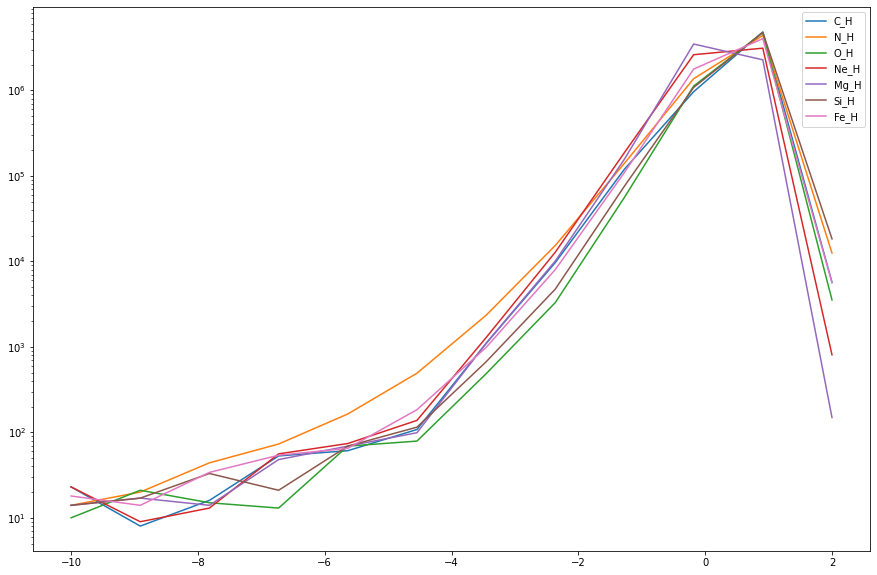

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
lim = [-10, 2]
x = np.linspace(*lim, lim[1] - lim[0])

for elem in solar_abundances.keys():
    index = f"{elem}_H"
    bins = master.count(binby=index, limits=lim, shape=lim[1] - lim[0])
    ax.plot(x, bins, label=index)

ax.set_yscale('log')
ax.legend()

plt.show()

In [14]:
master['Z'] = np.log10(master.Metallicity / 0.0153) # Correction for solar metallicity

### Fit relation
We plot [Z] vs [Fe/H]:

$$a x + b$$

\begin{split}\begin{bmatrix} S_{xx} & S_{x}  \\ S_x & N \end{bmatrix} \begin{bmatrix} a \\ b \end{bmatrix} = \begin{bmatrix} S_{xy} \\S_y   \end{bmatrix}\end{split}

or in sum form:

$$a = \frac{N\sum(xy) - \sum x \sum y}{N\sum (x^2) - (\sum x)^2}$$

$$b = \frac{\sum y - a\sum x}{N}$$

In [15]:
# https://www.astro.rug.nl/intranet/courses/PROGNUM2020/build/html/Notebooks/lingresOverview.html#Getting-the-best-fit-slope-and-offset-a-and-b-in-y=ax-+-b
sel = "(Z > -6) & (Z < 0)"
# sel = "(Z > -6)"
Sxy = master.sum('Z*FeH', selection=sel)
Sxx = master.sum('Z*Z', selection=sel)
Sx = master.sum('Z', selection=sel)
Sy = master.sum('FeH', selection=sel)
N = master.count(selection=sel)

# Linear least squares
delta = N*Sxx - Sx**2
a = (N*Sxy - Sx*Sy) / delta
b = (Sy*Sxx - Sxy*Sx) / delta

residuals = master.FeH - (a*master.Z + b)

# Uncertainties
var = master.sum(f'(FeH - {a}*Z + {b})**2', selection=sel) / (N - 2)
var_a = N*var / delta
var_b = Sxx*var / delta
s_a = np.sqrt(var_a)
s_b = np.sqrt(var_b)

print(f"{a = :.4f} +- {s_a:.4f}")
print(f"{b = :.4f} +- {s_b:.4f}")

a = 1.0116 +- 0.0007
b = -0.1457 +- 0.0003


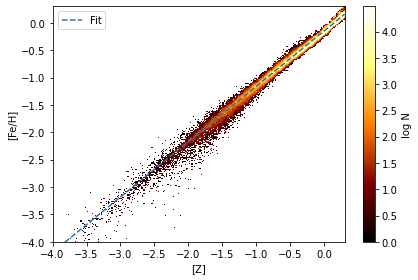

In [16]:
fig, ax = plt.subplots(1, 1)
plt.sca(ax)

master.viz.heatmap('Z', 'FeH', f='log10', what='count(*)', limits=[-4, 0.3], colorbar_label='log N')

lims = ax.get_xlim()
xs = np.linspace(*lims, 100)
ax.plot(xs, a*xs + b, ls='--', c='tab:blue', label='Fit')

ax.set_ylabel('[Fe/H]')
ax.set_xlabel('[Z]')
ax.legend()
ax.set_ylim(-4, 0.3)

plt.show()

1.011639156421528 -0.14570725647871116


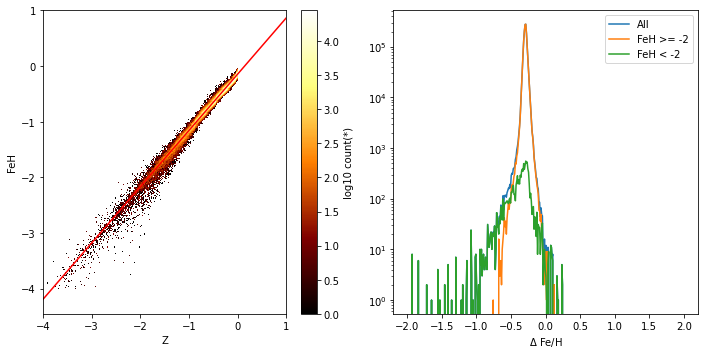

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

ax = axs[0]
plt.sca(ax)

# master.viz.scatter('Z', 'FeH', marker='.', length_check=False, selection=sel)
master.viz.heatmap('Z', 'FeH', f='log10', what='count(*)', limits=[-4, 1], selection=sel)
lims = ax.get_xlim()
xs = np.linspace(*lims, 100)
ax.plot(xs, a*xs + b, 'r')

ax = axs[1]
plt.sca(ax)
r_space = [-2, 2]
r_num = 400
print(a, b)
residuals = master.count(binby=f'FeH - ({a}*Z - {b})', selection=sel, limits=r_space, shape=r_num)
ax.plot(np.linspace(*r_space, r_num), residuals, label='All')
residuals = master.count(binby=f'FeH - ({a}*Z - {b})', selection=sel+'& (FeH >= -2)' , limits=r_space, shape=r_num)
ax.plot(np.linspace(*r_space, r_num), residuals, label='FeH >= -2')
residuals = master.count(binby=f'FeH - ({a}*Z - {b})', selection=sel+'& (FeH < -2)' , limits=r_space, shape=r_num)
ax.plot(np.linspace(*r_space, r_num), residuals, label='FeH < -2')
ax.legend()
ax.set_xlabel(r'$\Delta$ Fe/H')


ax.set_yscale('log')
plt.show()

In [18]:
master.mean(f'FeH - ({a}*Z - {b})', selection='(-4 < FeH) & (FeH < 0)')

array(-0.29080905)

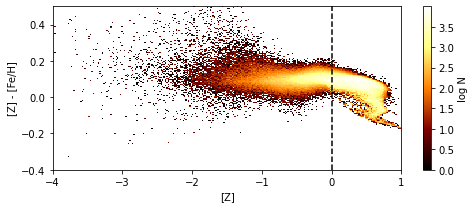

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(7, 3))
plt.sca(ax)
master.viz.heatmap('Z', 'Z - Fe_H', limits=[[-4, 1], [-0.4, 0.5]], f='log10', colorbar_label='log N')
ax.axvline(0, c='k', ls='--')
ax.set_ylabel("[Z] - [Fe/H]")
ax.set_xlabel("[Z]")
plt.show()

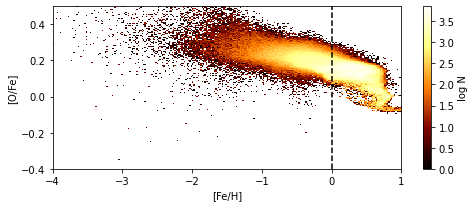

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(7, 3))
plt.sca(ax)
master.viz.heatmap('Fe_H', 'O_H - Fe_H', limits=[[-4, 1], [-0.4, 0.5]], f='log10', colorbar_label='log N')
ax.axvline(0, c='k', ls='--')
ax.set_ylabel("[O/Fe]")
ax.set_xlabel("[Fe/H]")
plt.show()

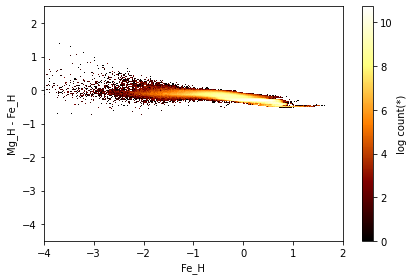

In [21]:
master.viz.heatmap('Fe_H', 'Mg_H - Fe_H', f='log', limits=[[-4, 2], [-4.5, 2.5]])

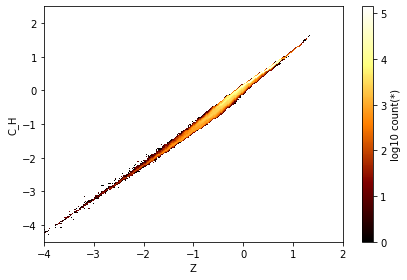

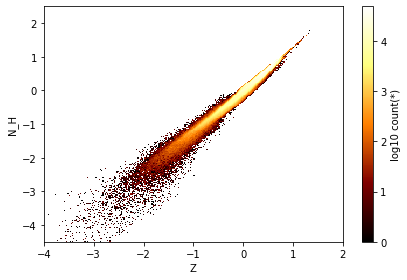

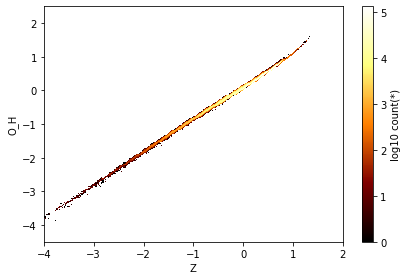

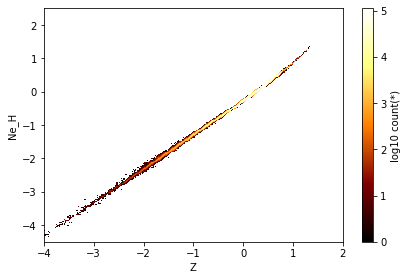

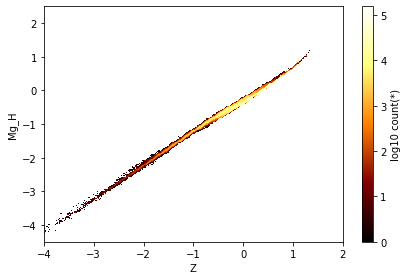

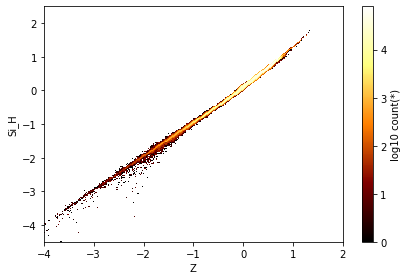

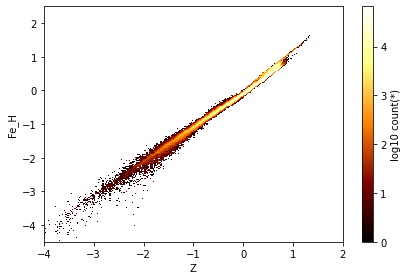

In [22]:
for elem in solar_abundances.keys():
    index = f"{elem}_H"
    master.viz.heatmap('Z', index, f='log10', limits=[[-4, 2], [-4.5, 2.5]])
    plt.show()

## Basic Initial Plots (exploratory)

(-15.0, 2.0)

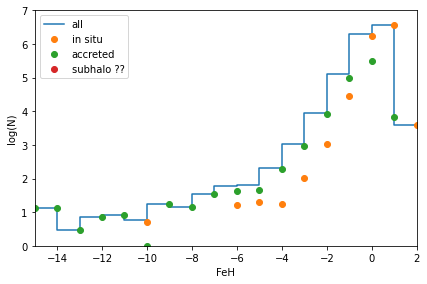

In [23]:
select = [
    None, master['AccretedFlag'] == -1, master['AccretedFlag'] == 0,
    master['AccretedFlag'] == 1
]
lss = ['-', ':', '-.', '--']
styles = [
    {'ls': '-', 'label': 'all'},
    {'ls': ' ', 'marker':'o', 'label':'in situ'},
    {'ls': ' ', 'marker':'o', 'label':'accreted'},
    {'ls': ' ', 'marker':'o', 'label':'subhalo ??'},
]
interval = [-15, 2]

fig, ax = plt.subplots(1, 1)
plt.sca(ax)
for s, styles in zip(select, styles):
    master.viz.histogram('FeH',
                         what='count(*)',
                         limits=interval,
                         selection=s,
                         shape=interval[1] - interval[0],
                         f='log10',
                         ylabel='log(N)',
                         **styles)
ax.legend()
ax.set_ylim(0, 7)
ax.set_xlim(*interval)

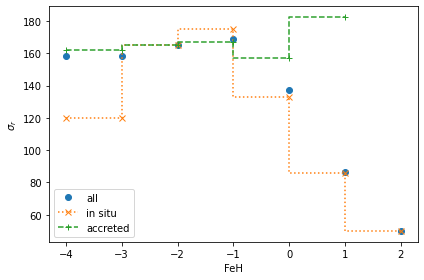

In [24]:
fig, ax = plt.subplots(1, 1)
plt.sca(ax)
interval = [-4, 2]
shape = interval[1] - interval[0]
master.viz.histogram('FeH', what='std(RadialVelocityObs)', limits=interval, shape=shape, 
                     linestyle='', marker='o', ylabel=r'$\sigma_r$', label='all')
master.viz.histogram('FeH', what='std(RadialVelocityObs)', limits=interval, shape=shape, 
                     linestyle=':', marker='x', ylabel=r'$\sigma_r$', selection='AccretedFlag == -1', label='in situ')
master.viz.histogram('FeH', what='std(RadialVelocityObs)', limits=interval, shape=shape, 
                     linestyle='--', marker='+', ylabel=r'$\sigma_r$', selection='AccretedFlag == 0', label='accreted')
ax.legend()
plt.show()

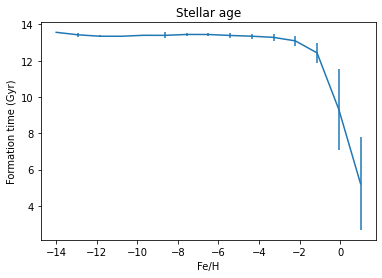

In [25]:
fig, ax = plt.subplots(1, 1)
plt.sca(ax)
interval = [-14, 1]
shape = interval[1] - interval[0]

means = master.mean('StellarFormationTime', binby='FeH', limits=interval, shape=shape)
std = master.std('StellarFormationTime', binby='FeH', limits=interval, shape=shape)
ax.errorbar(np.linspace(*interval, shape), means, yerr=std)

ax.set_xlabel('Fe/H')
ax.set_ylabel('Formation time (Gyr)')
ax.set_title('Stellar age')
plt.show()

## Investigating Parallax Issues
We seem to have observed parallaxes that have negative values.

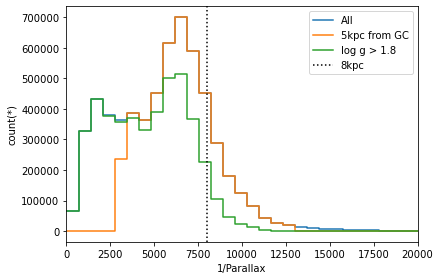

In [26]:
fig, ax = plt.subplots(1, 1)
plt.sca(ax)

master.viz.histogram('1/Parallax', label='All')
master.viz.histogram('1/Parallax', selection='abs(1/Parallax - 8000) < 5000', label='5kpc from GC')
master.viz.histogram('1/Parallax', selection='SurfaceGravity > 1.8', label='log g > 1.8')

ax.axvline(8000, color='k', ls=':', label='8kpc')

# ax.set_yscale('log')
# ax.set_xscale('log')
ax.set_xlim(0, 20000)
ax.legend()

plt.show()

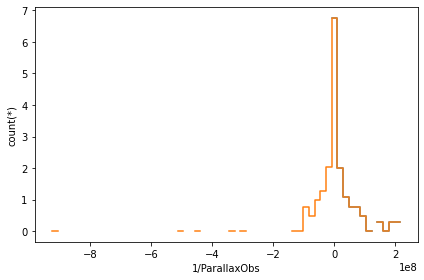

In [27]:
master.viz.histogram('1/ParallaxObs', f='log10', selection='ParallaxObs > 0')
master.viz.histogram('1/ParallaxObs', f='log10')

## Colour Magnitude Diagrams
We plot the colour using $GB - GR$ apparent magnitudes.

#### Absolute G magnitude
$$m - M = -2.5\log(d / 10pc)$$
$$\implies M = m + 2.5\log(d/10pc)$$

In [28]:
master['Distance'] = 1 / master['Parallax']
master['GabsMagnitude'] = master['Gmagnitude'] - 5*np.log10(master['Distance'] / 10)

master['DistanceObs'] = 1 / master['ParallaxObs']
master['GabsMagnitudeObs'] = master['GmagnitudeObs'] - 5*np.log10(master['DistanceObs'] / 10)

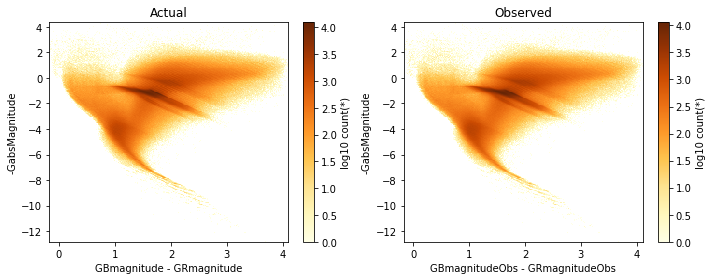

In [29]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs = axs.flatten()

ax = axs[0]
plt.sca(ax)
master.viz.heatmap('GBmagnitude - GRmagnitude', '-GabsMagnitude', f='log10', colormap='YlOrBr')
ax.set_title('Actual')

ax = axs[1]
plt.sca(ax)
master.viz.heatmap('GBmagnitudeObs - GRmagnitudeObs', '-GabsMagnitude', f='log10', colormap='YlOrBr')
ax.set_title('Observed')

plt.show()

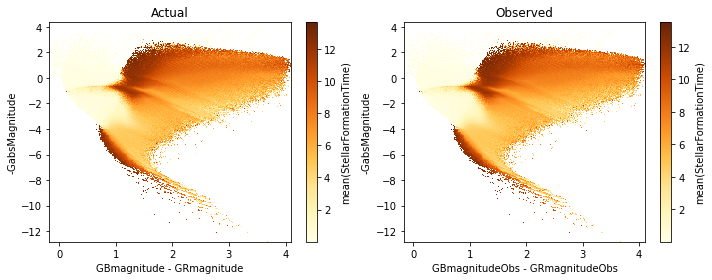

In [30]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs = axs.flatten()

ax = axs[0]
plt.sca(ax)
master.viz.heatmap('GBmagnitude - GRmagnitude',
                   '-GabsMagnitude',
                   what='mean(StellarFormationTime)',
#                    f='log10',
                   colormap='YlOrBr')
ax.set_title('Actual')

ax = axs[1]
plt.sca(ax)
master.viz.heatmap('GBmagnitudeObs - GRmagnitudeObs',
                   '-GabsMagnitude',
                   what='mean(StellarFormationTime)',
#                    f='log10',
                   colormap='YlOrBr')
ax.set_title('Observed')

plt.show()

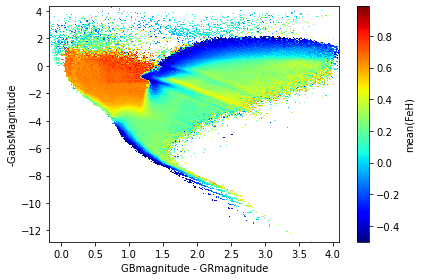

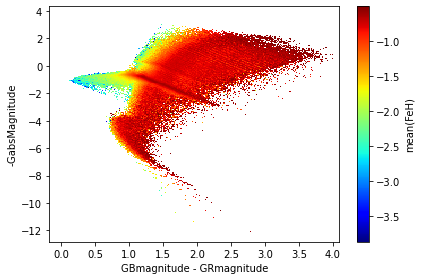

In [31]:
plt.figure()
master.viz.heatmap('GBmagnitude - GRmagnitude',
                   '-GabsMagnitude',
                   what='mean(FeH)',
                   colormap='jet',
                   selection='(FeH < 1) & (FeH > -0.5)')

plt.figure()
master.viz.heatmap('GBmagnitude - GRmagnitude',
                   '-GabsMagnitude',
                   what='mean(FeH)',
                   colormap='jet',
                   selection='(FeH < -0.5) & (FeH > -4)')

## Velocities
We have velocities $\mu_\alpha^*, \mu_\delta, v_r$ (in equatorial coordinates). First some general coordinate transformations:

The radial velocity correction can also be done with the aurigaia solar motion: it is given to be $$(U_\odot, V_\odot, W_\odot) = (11.1, 12.24, 7.25) km/s$$ w.r.t **LSR**.

Also the position is given to be $$ R_\odot= 8kpc, Z_\odot = 0.02kpc$$

TODO:
- Use the sun position, and velocity w.r.t LSR from auriga. Also get LSR from auriga.
- It might not be needed to convert the data to cartesian (we have heliocentric)

In [32]:
# Taken from: https://docs.astropy.org/en/stable/generated/examples/coordinates/rv-to-gsr.html?highlight=local%20standard%20of%20rest
import astropy.coordinates as coord
from astropy import units as u

def rv_to_gsr(c, v_sun=None):
    """Transform a barycentric radial velocity to the Galactic Standard of Rest
    (GSR).

    The input radial velocity must be passed in as a

    Parameters
    ----------
    c : `~astropy.coordinates.BaseCoordinateFrame` subclass instance
        The radial velocity, associated with a sky coordinates, to be
        transformed.
    v_sun : `~astropy.units.Quantity`, optional
        The 3D velocity of the solar system barycenter in the GSR frame.
        Defaults to the same solar motion as in the
        `~astropy.coordinates.Galactocentric` frame.

    Returns
    -------
    v_gsr : `~astropy.units.Quantity`
        The input radial velocity transformed to a GSR frame.

    """
    if v_sun is None:
        v_sun = coord.Galactocentric().galcen_v_sun.to_cartesian()

    gal = c.transform_to(coord.Galactic)
    cart_data = gal.data.to_cartesian()
    unit_vector = cart_data / cart_data.norm()

    v_proj = v_sun.dot(unit_vector)

    return c.radial_velocity + v_proj

In [33]:
# https://docs.astropy.org/en/stable/coordinates/velocities.html#radial-velocity-corrections
@vaex.register_function()
def correct_radial_gsr(ra, dec, v_r):
    # Construct the SkyCoord object
    c = SkyCoord(ra*u.rad,
                 dec*u.rad,
                 frame='icrs',
                 radial_velocity=v_r * u.km / u.s,
                )
    v_gsr = rv_to_gsr(c)
    return v_gsr

In [34]:
master['RadialVelocityGSR'] = master.func.correct_radial_gsr(master.RA, master.Dec, master.RadialVelocity)
master['RadialVelocityGSRObs'] = master.func.correct_radial_gsr(master.RAObs, master.DecObs, master.RadialVelocityObs)

## Define observation fields
As given by the pointings from Anke in `fieldcenters_spec.csv`.

In [35]:
import csv
pointings_fn = './data/fieldcenters_spec.csv'
select = 2  # control the number of pointings

def read_pointings(filename):
    ls = []
    bs = []
    with open(filename, 'r') as f:
        reader = list(csv.reader(f))
        for line in reader[1:]:
            l, b = line
            ls.append(float(l.strip()))
            bs.append(float(b.strip()))

    ls = np.array(ls)
    bs = np.array(bs)
    return ls, bs

ls, bs = read_pointings(pointings_fn)
pointings = SkyCoord(ls[select], bs[select], unit=u.deg, frame='galactic')

In [36]:
@vaex.register_function(on_expression=False)
def sky_angle(c_l, c_b, ra, dec):
    center = SkyCoord(c_l, c_b, unit=u.deg, frame='galactic')
    coords = SkyCoord(ra, dec, unit=u.rad, frame='icrs')
    return center.separation(coords).to(u.deg).value

for i, (l, b) in enumerate(zip(ls, bs)):
    master[f'Point{i}Separation'] = master.func.sky_angle(l, b, master.RA, master.Dec)

In [37]:
points = [f"Point{i}Separation" for i in range(len(ls))]
master[points]

#          Point0Separation    Point1Separation    Point2Separation    Point3Separation    Point4Separation    Point5Separation    Point6Separation    Point7Separation    Point8Separation    Point9Separation    Point10Separation    Point11Separation    Point12Separation    Point13Separation    Point14Separation    Point15Separation    Point16Separation    Point17Separation    Point18Separation    Point19Separation    Point20Separation
0          13.988527010895572  9.968659581159137   10.383116436796945  12.061180744154365  11.869467282576865  12.517905525841298  7.306966985796238   9.406002757942373   13.501125764558605  12.489842485532936  10.40790570140706    7.7566820749315255   9.213049591235444    4.812977144716125    6.192705675164687    11.884264144558056   4.129551036218164    3.1660750178890478   7.427261461909511    6.2262135887297365   8.33771834785297
1          14.167479234215119  10.095071295214568  10.187345610163305  12.18458828624698   12.044657992172311  12.670437802401736  7.471363366494327   9.224624549848986   13.302148949594145  12.29743840775261   10.240649807988762   7.564323283303443    9.014295789281723    4.6444792689912155   5.981375005017619    11.710621278378175   3.9217794177446956   3.0047845719140334   7.265137026700161    6.021846333713305    8.127117623481114
2          14.146244865154998  10.070712470130601  10.206340647608277  12.16014673696529   12.023045249758564  12.647120977371584  7.448861064372626   9.245732888762205   13.320485765787812  12.317007783532931  10.263106242240172   7.583942112494145    9.032708623519396    4.666923831532221    5.99564309535412     11.732516752608378   3.9377918028912213   3.0278420954670273   7.288003951534092    6.03892000601337     8.141782330869422
3          14.137917089395751  10.058927189489562  10.212823057087654  12.148215369871048  12.01437562806936   12.636727345204823  7.43934224967137    9.253973321337417   13.32645163133788   12.323945973400905  10.272604340498866   7.590929032267848    9.038739781716355    4.676423074331037    5.998698659516523    11.74147075440539    3.942079804571438    3.037985381652757    7.29792591591869     6.04395566341568     8.14509884681125
4          14.216035630914837  10.146916038532483  10.142268287677133  12.236428292353724  12.093744695770706  12.721595228848154  7.521615603246961   9.176299896177657   13.258130428854306  12.251437283821547  10.190488926227227   7.518268258371176    8.970174021192838    4.594351876453021    5.944479277850397    11.661188184664876   3.88185832409696     2.9539366521625396   7.214485934864278    5.980010817427745    8.089464515704611
...        ...                 ...                 ...                 ...                 ...                 ...                 ...                 ...                 ...                 ...                 ...                  ...                  ...                  ...                  ...                  ...                  ...                  ...                  ...                  ...                  ...
5,948,494  17.119700616857045  16.949265832928578  17.184239846366182  18.703512441722246  15.871342578045851  17.714317487635615  13.630350556007391  15.516476148928149  19.955299932815088  18.569027374884758  15.371391698592607   15.056684424403741   16.524951037339342   12.382044669731805   15.346454577740912   16.790922375495313   13.583997437475798   11.676129194382192   13.327049518008588   14.773956403289016   16.94049662044894
5,948,495  15.865905999902347  16.499903566140357  19.242071468797647  18.080579301694424  14.868265201491228  16.836922596052606  13.317096828609566  17.604102892549232  22.10090891256338   20.72864804872741   17.56271376474054    16.99426226112913    18.506822083142662   14.147370342543422   17.027076161518902   19.018809952005938   15.140420355872324   13.242530555326182   15.355057588256356   16.53005073005814    18.756997400818506
5,948,496  20.91062729069138   18.440375181081887  10.0676206905

In [38]:
@vaex.register_function()
def min_columns(c1, *cols):
    minimum = c1
    for c in cols:
        minimum = np.minimum(minimum, c)
    return minimum

# master['MinDistance'] = np.minimum(getattr(master, p) for p in points)
master['MinDistance'] = master.func.min_columns(*[getattr(master, p) for p in points])

In [39]:
if False:
    fields = master.filter('MinDistance < 1')
    fields.viz.heatmap('ld', 'bd', what='mean(MinDistance)')
    plt.scatter(ls, bs, marker='*')
    
    # Export the selection to a new file
    fields.export('fields.hdf5')

## Recreating Plots from paper

### Figure 2: log g vs Teff
$\log g$ vs $T_{eff}$, with color as metallicity.

(from PIGS I)
Extra lines at: $\log g = (1.8, 3.2)$
And at
$\log g = T_{eff} / 480 - 8.1$

now altered, to get a better selection.

In [40]:
# min_g = 1.8
min_g = 2.5
max_g = 3.2
# line = lambda T: T / 480 - 8.1
slope = 300
offset = 15.1
inv_line = lambda g: slope*(g + offset)

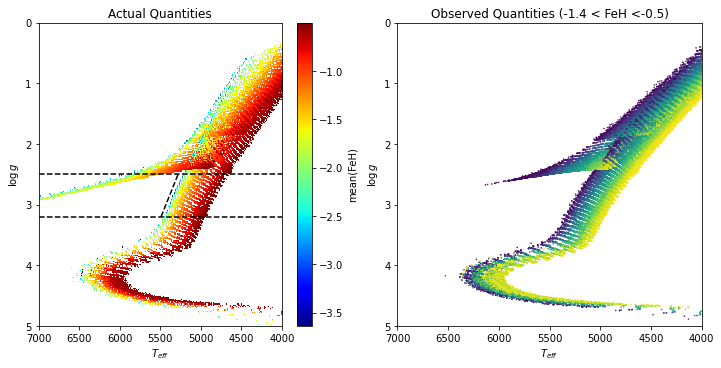

In [41]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

ax = axs[0]
plt.sca(ax)
master.viz.heatmap('EffectiveTemperature',
                   'SurfaceGravity',
                   what='mean(FeH)',
                   limits=[[4000, 7000], [0, 5]],
                   selection='(FeH <-0.5) & (FeH > -4)',
                   colormap='jet')

ax.set_ylabel(r'$\log g$')
ax.set_xlabel(r'$T_{eff}$')
ax.invert_xaxis()
ax.invert_yaxis()
ax.axhline(min_g, ls='--', color='k')
ax.axhline(max_g, ls='--', color='k')

# Add additional cut:
# log g = Teff / 480 - 8.1
(a, b) = inv_line(max_g), inv_line(min_g)
ax.plot([a, b], [max_g, min_g], ls='--', color='k')

ax.set_title("Actual Quantities")


ax = axs[1]
plt.sca(ax)
master.viz.scatter('EffectiveTemperature', 'SurfaceGravity', s=0.3, c_expr='FeH', selection='(FeH <-0.5) & (FeH > -1.4)', length_check=False)

ax.set_title("Observed Quantities (-1.4 < FeH <-0.5)")
ax.set_ylabel(r'$\log g$')
ax.set_xlabel(r'$T_{eff}$')
ax.set_ylim(0, 5)
ax.set_xlim(4000, 7000)
ax.invert_xaxis()
ax.invert_yaxis()

plt.show()

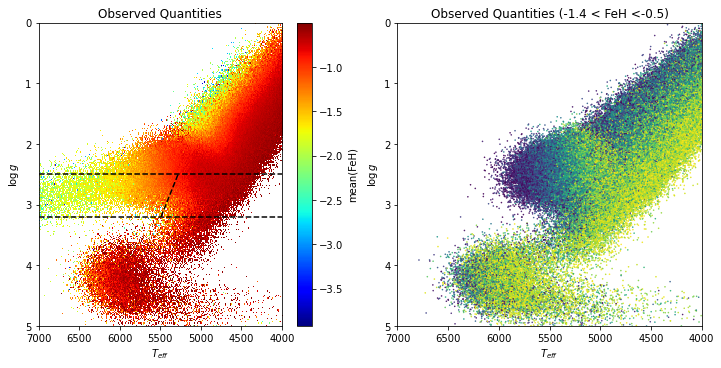

In [42]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

ax = axs[0]
plt.sca(ax)
master.viz.heatmap('EffectiveTemperatureObs',
                   'SurfaceGravityObs',
                   what='mean(FeH)',
                   limits=[[4000, 7000], [0, 5]],
                   selection='(FeH <-0.5) & (FeH > -4)',
                   colormap='jet')

ax.set_ylabel(r'$\log g$')
ax.set_xlabel(r'$T_{eff}$')
ax.invert_xaxis()
ax.invert_yaxis()
ax.axhline(min_g, ls='--', color='k')
ax.axhline(max_g, ls='--', color='k')

# Add additional cut:
# log g = Teff / 480 - 8.1
(a, b) = inv_line(max_g), inv_line(min_g)
ax.plot([a, b], [max_g, min_g], ls='--', color='k')

ax.set_title("Observed Quantities")


ax = axs[1]
plt.sca(ax)
master.viz.scatter('EffectiveTemperatureObs', 'SurfaceGravityObs', s=0.3, c_expr='FeH', selection='(FeH <-0.5) & (FeH > -1.4)', length_check=False)

ax.set_ylabel(r'$\log g$')
ax.set_xlabel(r'$T_{eff}$')
ax.set_title("Observed Quantities (-1.4 < FeH <-0.5)")
ax.set_ylim(0, 5)
ax.set_xlim(4000, 7000)
ax.invert_xaxis()
ax.invert_yaxis()

plt.show()

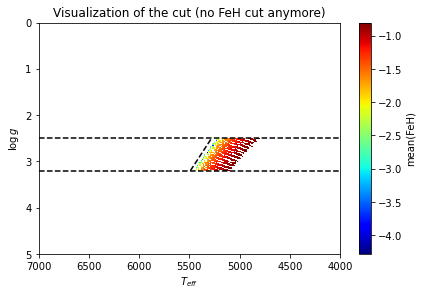

In [43]:
all_selection = f'(SurfaceGravity > {min_g}) & (SurfaceGravity < {max_g}) & (FeH < -0.8) & (abs(1/Parallax) - 8000 < 5000)'
giant_selection = all_selection + f' & (SurfaceGravity > EffectiveTemperature / {slope} - {offset})'
hb_selection = all_selection + f' & (SurfaceGravity <= EffectiveTemperature / {slope} - {offset})'

fig, ax = plt.subplots(1, 1)

plt.sca(ax)
master.viz.heatmap('EffectiveTemperature',
                   'SurfaceGravity',
                   what='mean(FeH)',
                   limits=[[4000, 7000], [0, 5]],
                   selection=giant_selection,
                   colormap='jet')

ax.set_ylabel(r'$\log g$')
ax.set_xlabel(r'$T_{eff}$')
ax.invert_xaxis()
ax.invert_yaxis()
ax.axhline(min_g, ls='--', color='k')
ax.axhline(max_g, ls='--', color='k')

# Add additional cut:
# log g = Teff / 480 - 8.1
(a, b) = inv_line(max_g), inv_line(min_g)
ax.plot([a, b], [max_g, min_g], ls='--', color='k')

ax.set_title("Visualization of the cut (no FeH cut anymore)")
plt.show()

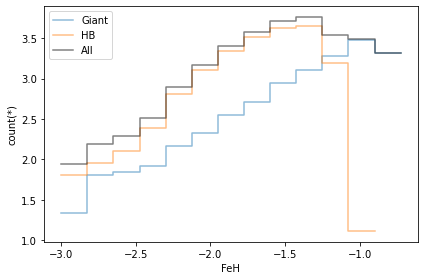

In [44]:
master.viz.histogram('FeH', selection=giant_selection, limits=[-3, 0.5], shape=20, f='log10', label='Giant', alpha=0.5)
master.viz.histogram('FeH', selection=hb_selection, limits=[-3, 0.5], shape=20, f='log10', label='HB', alpha=0.5)
master.viz.histogram('FeH', selection=all_selection, limits=[-3, 0.5], shape=20, f='log10', label='All', color='k', alpha=0.5)
plt.legend()
plt.show()

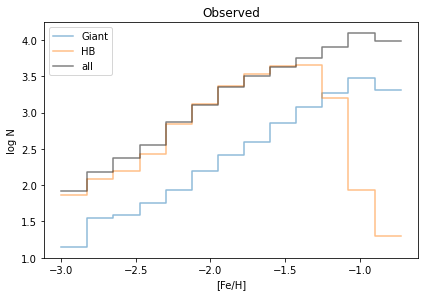

In [45]:
all_selection_obs = f'(SurfaceGravityObs > {min_g}) & (SurfaceGravityObs < {max_g}) & (FeH < -0.8) & (abs(1/Parallax) - 8000 < 5000)'
giant_selection_obs = all_selection + f' & (SurfaceGravityObs > EffectiveTemperatureObs / {slope} - {offset})'
hb_selection_obs = all_selection + f' & (SurfaceGravityObs <= EffectiveTemperatureObs / {slope} - {offset})'

master.viz.histogram('FeH', selection=giant_selection_obs, limits=[-3, 0.5], shape=20, f='log10', label='Giant', alpha=0.5)
master.viz.histogram('FeH', selection=hb_selection_obs, limits=[-3, 0.5], shape=20, f='log10', label='HB', alpha=0.5)
master.viz.histogram('FeH', selection=all_selection_obs, limits=[-3, 0.5], shape=20, f='log10', color='k', alpha=0.5, label='all')

plt.xlabel('[Fe/H]')
plt.ylabel('log N')
plt.title('Observed')
plt.legend()
plt.show()

#### Quality of quantities

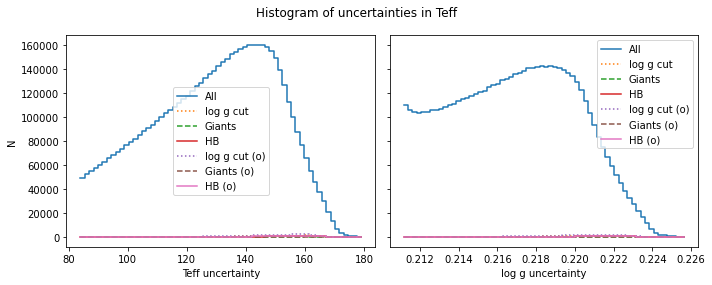

In [46]:
selections = [None, all_selection, giant_selection, hb_selection, all_selection_obs, giant_selection_obs, hb_selection_obs]
names = ["All", "log g cut", "Giants", "HB", "log g cut (o)", "Giants (o)", "HB (o)"]
lstyles = ["-", ":", "--", "-", ":", "--", "-"]

fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

for n, s, ls in zip(names, selections, lstyles):
    plt.sca(axs[0])
    master.viz.histogram('EffectiveTemperatureError', selection=s, label=n, linestyle=ls)
    
    plt.sca(axs[1])
    master.viz.histogram('SurfaceGravityError', selection=s, label=n, linestyle=ls)
    
axs[0].legend()
axs[1].legend()

axs[0].set_ylabel('N')
axs[1].set_ylabel('')
axs[0].set_xlabel('Teff uncertainty')
axs[1].set_xlabel('log g uncertainty')

fig.suptitle('Histogram of uncertainties in Teff')
fig.tight_layout()

plt.show()

### Figure 3 - top row (with actual quantities)

In [47]:
read_fields = vaex.open('fields.hdf5')

In [48]:
def plot_velocities(df, fe_bins=None, v_r_argument="RadialVelocityGSR"):

    fig, axs = plt.subplots(2, 4, figsize=(11, 5), sharex=True)

    if not fe_bins:
        fe_bins = [[-1, -0.5], [-1.5, -1], [-2, -1.5], [-3, -2]]

    for i, b in zip(range(len(axs[0])), fe_bins):
        selection = f'(FeH <= {b[1]}) & (FeH > {b[0]}) & (SurfaceGravity > 1.8) & (SurfaceGravity < 3.2)'
        params = {'binby': 'l_wrap', 'limits': [-12, 12], 'shape':20, 'selection': selection}

        means = df.mean(v_r_argument, **params)
        std = df.std(v_r_argument, **params)
        N = df.count(**params)

        yerr = std / np.sqrt(N)
        avg_bin = np.mean(N)

        ax = axs[0][i]
        ax_s = axs[1][i]

        l_space = np.linspace(*params['limits'], params['shape'])

        ax_s.plot(l_space, std, label='Actual', ls=' ', marker='o')
        ax.errorbar(l_space, means, yerr=yerr, label='Actual', ls=' ', marker='o')

        ax.text(-10, -60, f"avg bin size = {avg_bin:.0f}")

        ax.set_title(f"[Fe/H] = {b[1]} to {b[0]}")
        ax_s.set_xlabel('l (deg)')
        ax.invert_xaxis()
        
        if i > 0:
            ax.set_yticklabels([])
            ax_s.set_yticklabels([])

        ax.set_ylim(-70, 70)
        ax_s.set_ylim(150, 200)

    axs[0][0].set_ylabel(r'mean $V_r$ (km/s)')
    axs[1][0].set_ylabel(r'std $V_r$ (km/s)')
    
    fig.tight_layout()
    
    return fig, axs

In [49]:
# fig, axs = plot_velocities(read_fields)
# plt.show()

# fig, axs = plot_velocities(read_fields, v_r_argument="RadialVelocityGSRObs")
# plt.show()

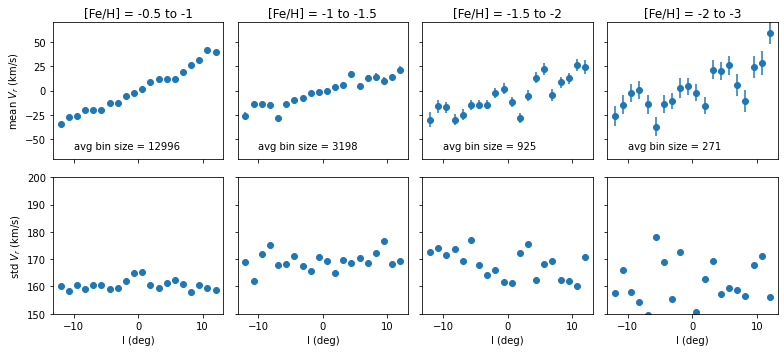

In [50]:
fig, axs = plot_velocities(master)
plt.show()

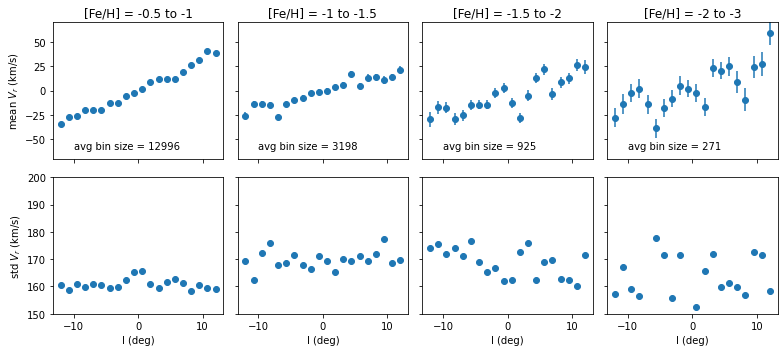

In [51]:
fig, axs = plot_velocities(master, v_r_argument="RadialVelocityGSRObs")
plt.show()

## Exploring Snapshot

In [52]:
print(snap.groupby('AccretedFlag', agg='count'))
print()
print(master.groupby('AccretedFlag', agg='count'))

  #    AccretedFlag     count
  0              -2     73755
  1              -1  13571700
  2               0   1952807
  3               1    870193

  #    AccretedFlag    count
  0               0   432426
  1              -1  5516073


---------------------------------------- X-Y ----------------------------------------


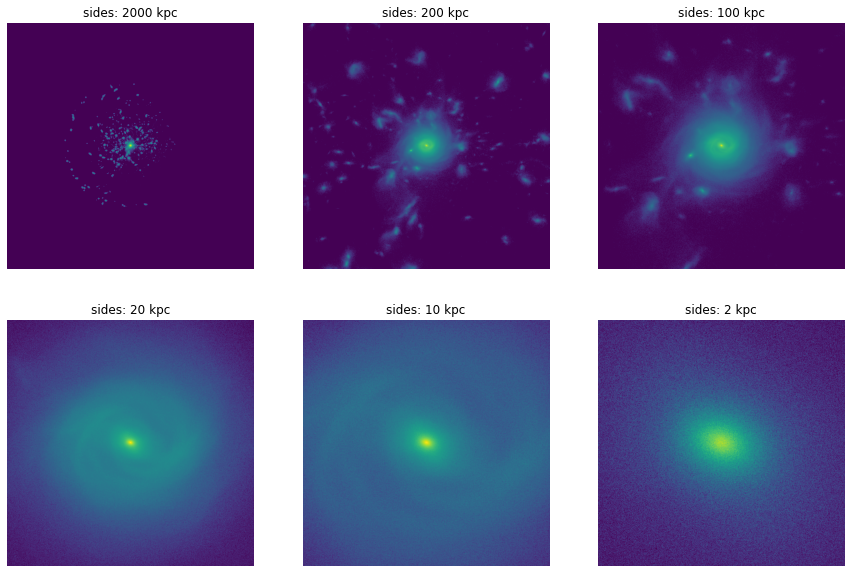

---------------------------------------- X-Z ----------------------------------------


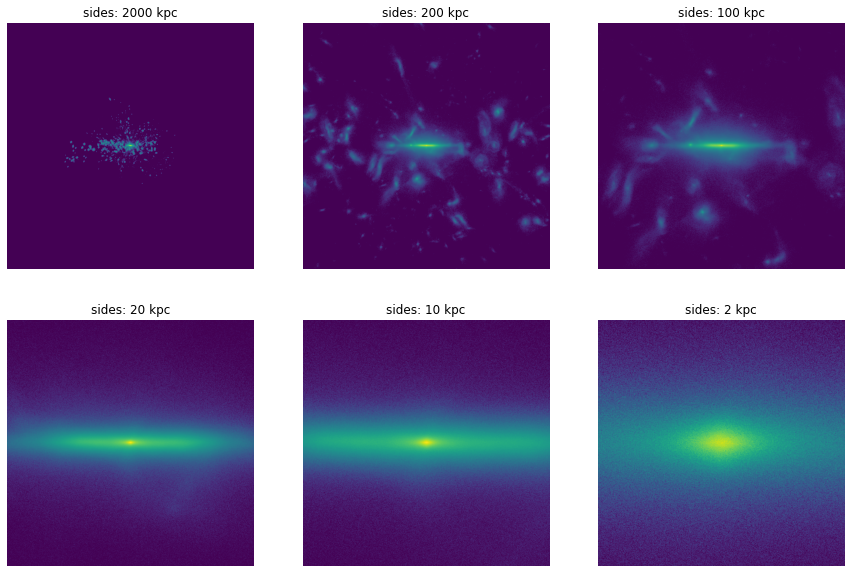

---------------------------------------- Y-Z ----------------------------------------


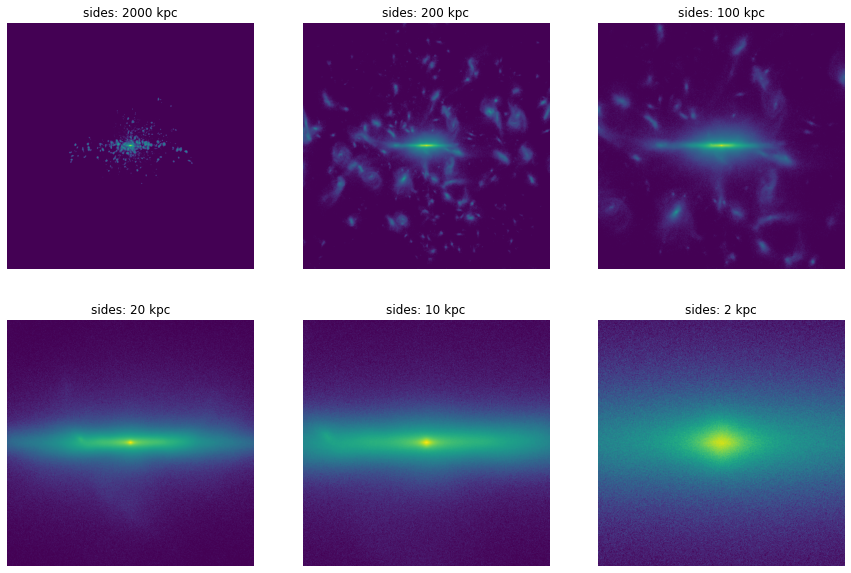

In [53]:
x = 'XBirthPos'
y = 'YBirthPos'
z = 'ZBirthPos'

comb = [[x, y], [x, z], [y, z]]
lst = ["X-Y", "X-Z", "Y-Z"]

for c, l in zip(comb, lst):
    print("-"*40, l, "-"*40)
    fig, axs = plt.subplots(2, 3, figsize=(15,10))
    axs = axs.flatten()
    resolutions = [1, .1, 0.05, .01, 0.005, .001]
    for ax, r in zip(axs, resolutions):
        b = np.log10(1 + snap.count(binby=c, limits=[-r, r], shape=(1000, 1000)))
        ax.imshow(b.T, extent=[-r, r, -r, r], origin='lower')
        ax.set_title(f"sides: {2*r*1000:.0f} kpc")
        ax.set_axis_off()

    plt.show()

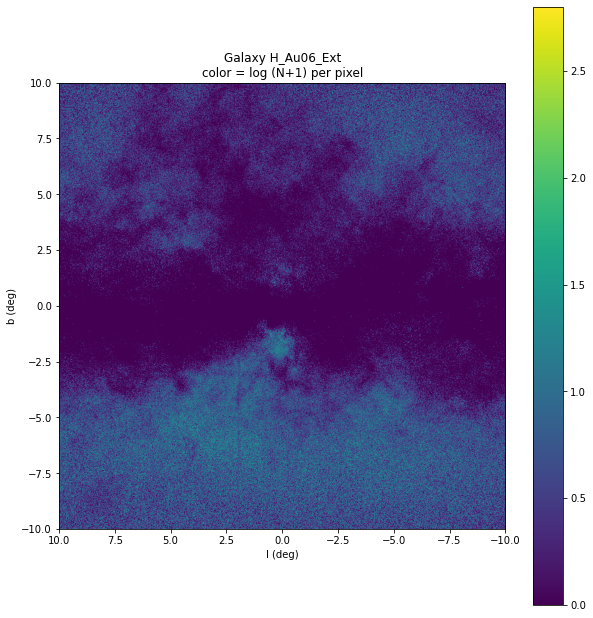

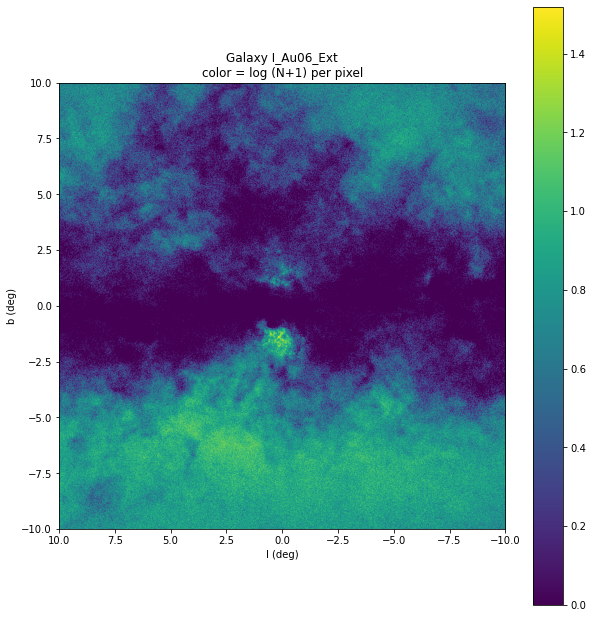

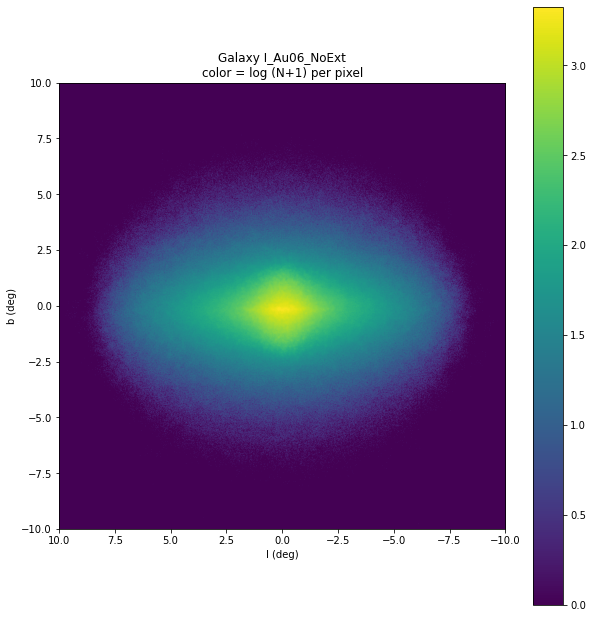

In [54]:
sets = ['H_Au06_Ext', 'I_Au06_Ext', 'I_Au06_NoExt']
shapes = [400, 1000, 1000]
for s in sets:
    df = vaex.open(f'./data/{s}.hdf5')
    df['ld'] = df['l'] * 180 / 3.1415
    df['bd'] = df['b'] * 180 / 3.1415
    
    # Plot
    fig, ax = plt.subplots(1, 1, figsize=(10, 11))

    bins = np.log10(1 + df.count(binby=['ld', 'bd'], limits=(-10, 10), shape=1000))
    im = ax.imshow(bins.T, extent=[-10, 10, -10, 10], origin='lower')

    fig.colorbar(im, ax=ax)

    ax.set_title(f"Galaxy {s}\ncolor = log (N+1) per pixel")
    ax.invert_xaxis()
    ax.set_xlabel('l (deg)')
    ax.set_ylabel('b (deg)')
    plt.show()

## Manual Conversion of Snapshot data

In [55]:
# We don't want to do this always, so disable
if False:
    try:
        f.close()
    except:
        print('already closed')

    # We first read columns from the original file
    f = h5py.File('./data/snapshot_reduced_halo_6_063.hdf5', 'r')

    # Extract relevant columns
    metll = f['PartType4']['GFM_Metallicity']
    mets = f['PartType4']['GFM_Metals']
    pis = f['PartType4']['ParticleIDs']
    age = f['PartType4']['GFM_StellarFormationTime']
    accreted = f['PartType4']['AccretedFlag']
    bp = f['PartType4']['BirthPos']
    bv = f['PartType4']['BirthVel']
    im = f['PartType4']['GFM_InitialMass']


    try:
        rf.close()
    except:
        print('already closed')

    # And then put them as signle column arrays in a new file.
    rf = h5py.File('./data/snapshot_halo_06_custom.hdf5', 'w')
    
    # Identities
    rf.create_dataset('ParticleIDs', data=pis, dtype='uint64')
    rf.create_dataset('AccretedFlag', data=accreted, dtype='int64')
    
    # Quantities
    rf.create_dataset('Metallicity', data=metll)
    rf.create_dataset('StellarFormationTime', data=age)
    rf.create_dataset('GFM_InitialMass', data=im)

    # Quantities with higher dimensions (need to be split)
    coords = ['Z', 'Y', 'X']
    for i, coord in enumerate(coords):
        rf.create_dataset(f"{coord}BirthPos", data=bp[:, i])
        rf.create_dataset(f"{coord}BirthVel", data=bv[:, i])
    
    metals = ['H', 'He', 'C', 'N', 'O', 'Ne', 'Mg', 'Si', 'Fe']
    for i, met in enumerate(metals):
        rf.create_dataset(f"{met}Abundance", data=mets[:, i])
        
    rf.close()
    f.close()